## Cleaning FERC 1 Fuel data
This notebook is meant to help get you understand the data cleaning process for FERC Form 1 fuel data for heat content and price per MMBTU data.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..')))
from pudl import pudl, ferc1, eia923, settings, constants
from pudl import models, models_ferc1, models_eia923
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pudl_engine = pudl.db_connect_pudl()

### Define a function to clean data frames
First, let's pull in the applicable data from the PUDL FERC tables.

In [3]:
# First, let's pull in the applicable data from the PUDL FERC tables:
fuel_df = pd.read_sql('''SELECT * from fuel_ferc1''',pudl_engine)
coal = fuel_df[fuel_df.fuel=='coal']
gas = fuel_df[fuel_df.fuel=='gas']

## Z: What kind of errors are we fixing? Why is this kind of function a reasonable thing to do?
Then, we'll define a function that takes as arguments: 

- a data series to be cleaned
- minimum and maximum values bounding the reasonable range of values for the series
- multipliers (a list) to the minimum and maximum values are divided to define additional ranges of data, which are brought into the reasonable range by multiplying the values in the additional ranges by the multipliers (e.g. if a set of values is 1000 times too large to fit in the reasonable range, its multiplier will be .001).

The function will return a cleaned series.

In [4]:
def fixit(tofix, min, max, mults):
    
    fixed = tofix.copy()
    for mult in mults:
        fixed = fixed.apply(lambda x: x*mult if x > min/mult and x < max/mult else x)
    fixed = fixed.apply(lambda x: np.nan if x < min or x > max else x)
    return(fixed)

We'll next define a function to show us graphs of what the data looks like before and after it is cleaned, and to show us how much data the cleaning process was not able to clean. This function will take 5 arguments:

- a series of data to be cleaned
- a series of data which has been cleaned by the cleaning function
- the title (string) to apply to the before and after graphs
- the x label (string) to apply to the before and after graphs
- the y label (string) to apply to the before and after graphs

The function will returned the before and after graphs and the percentage of how many values were not cleaned and were instead set to NaN.
## Z: Could you put the percentage of data lost into the figure, instead of returning it?

In [5]:
def showfix(tofix,fixed,title,xlabel,ylabel):
    
    min_1 = tofix[tofix > 0].min()
    max_1 = tofix.max()
    
    fig_1 = plt.figure(figsize=(14,10))
    plt.subplot(2,1,1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    ax = fig_1.axes[0]
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.xlim(min_1,max_1)
    plt.hist(tofix, bins=np.logspace(np.log10(min_1), np.log10(max_1), 100))
    
    plt.subplot(2,1,2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.hist(fixed.dropna(),bins=100)
    plt.show()
    
    fraction_lost =  ( fixed.isnull().sum() / len(fixed) )
    
    return(fig_1, fraction_lost)

### FERC Form 1 Average heat content
Let's use these two functions to clean the average heat content of Form 1 coal and gas data, respectively.
## Z: Why 10 and 30? Why 2000, 1e6 and 2000e6? Short explanation of why the distribution looks like it does when it's clean? (subbituminous vs. bituminous coals). Why is it reasonable to use log-log in the first panel, and linear scales in the 2nd?

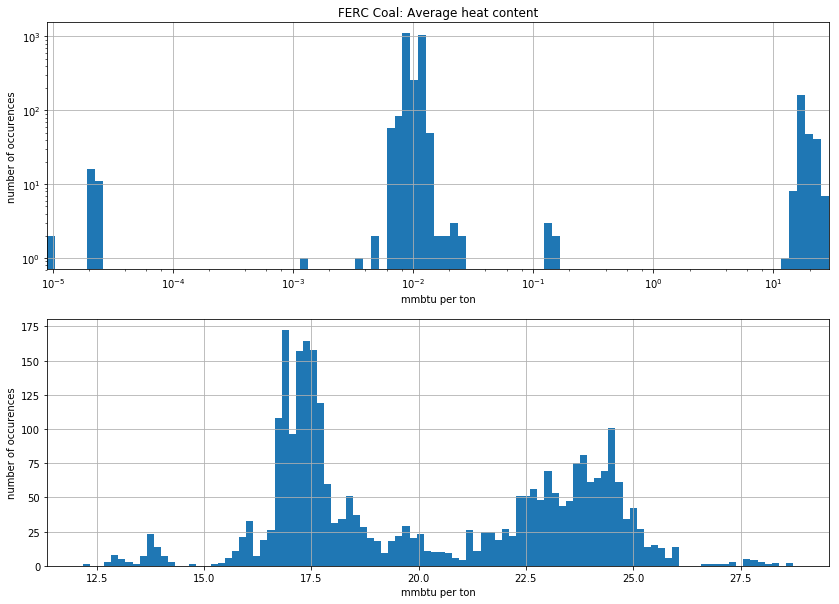

In [6]:
to_fix_avg_heat_content_coal = coal.fuel_avg_mmbtu_per_unit
fixed_avg_heat_content_coal = fixit(coal.fuel_avg_mmbtu_per_unit,10,30,[2000,1e6,2000e6])

# Notice here that I'm capturing the output of the function in fig, fraction_lost
fig, fraction_lost = showfix(to_fix_avg_heat_content_coal,fixed_avg_heat_content_coal,'FERC Coal: Average heat content',\
        'mmbtu per ton','number of occurences')

## Z: Why 0.75 and 1.25? Why 1000 and 1e6?

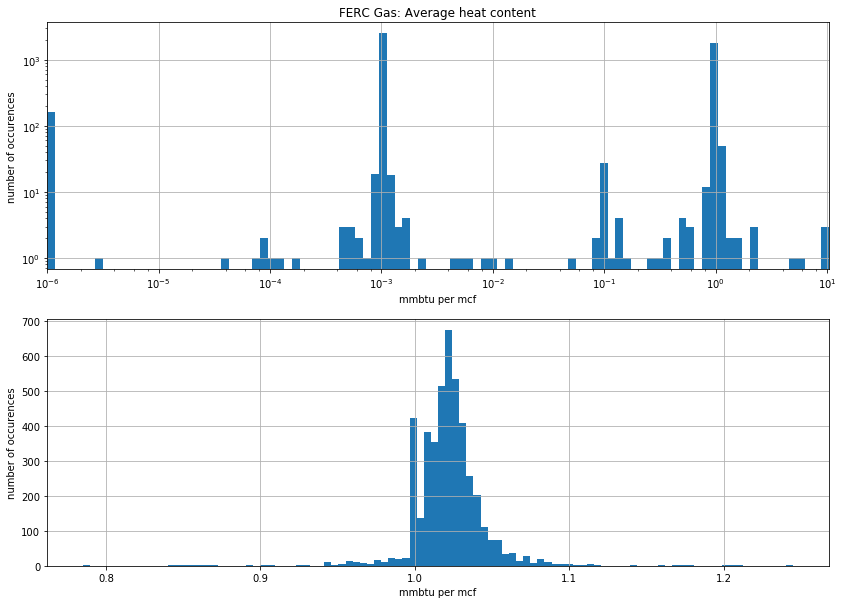

In [7]:
to_fix_avg_heat_content_gas = gas.fuel_avg_mmbtu_per_unit
fixed_avg_heat_content_gas = fixit(gas.fuel_avg_mmbtu_per_unit,.75,1.25,[1000,1e6])

fig, fraction_lost = showfix(to_fix_avg_heat_content_gas,fixed_avg_heat_content_gas,'FERC Gas: Average heat content',\
        'mmbtu per mcf','number of occurences')

### FERC Form 1 Cost per mmbtu
Let's use these two functions to clean the cost per mmbtu of Form 1 coal and gas data, respectively.
## Z: Why 0.5 and 7.5? Why 0.1 and 2000? 

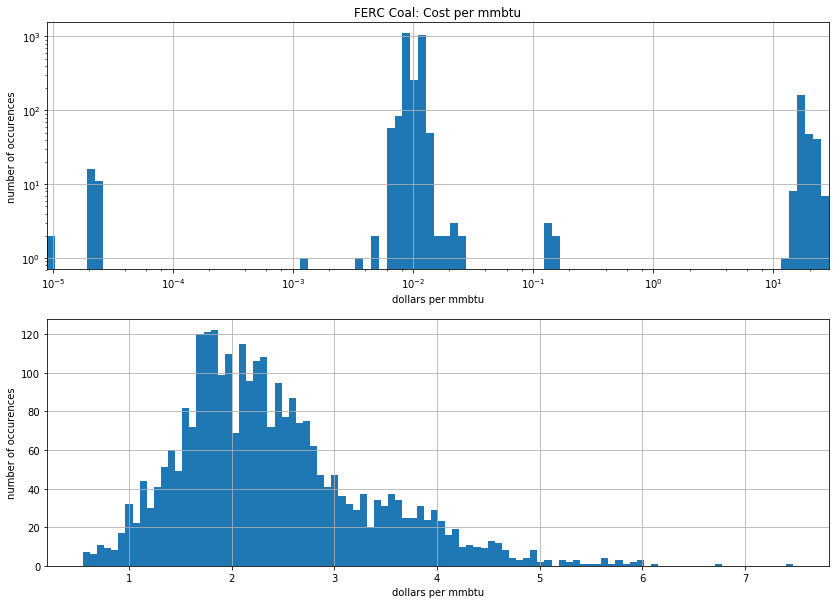

In [8]:
to_fix_cost_per_mmbtu_coal = coal.fuel_cost_per_mmbtu
fixed_cost_per_mmbtu_coal = fixit(coal.fuel_cost_per_mmbtu,.5,7.5,[.01,2000])

fig, fraction_lost = showfix(to_fix_avg_heat_content_coal,fixed_cost_per_mmbtu_coal,'FERC Coal: Cost per mmbtu',\
        'dollars per mmbtu','number of occurences')

## Z: Why 2.5 & 17.5? Why 0.1, 1000, and 10?

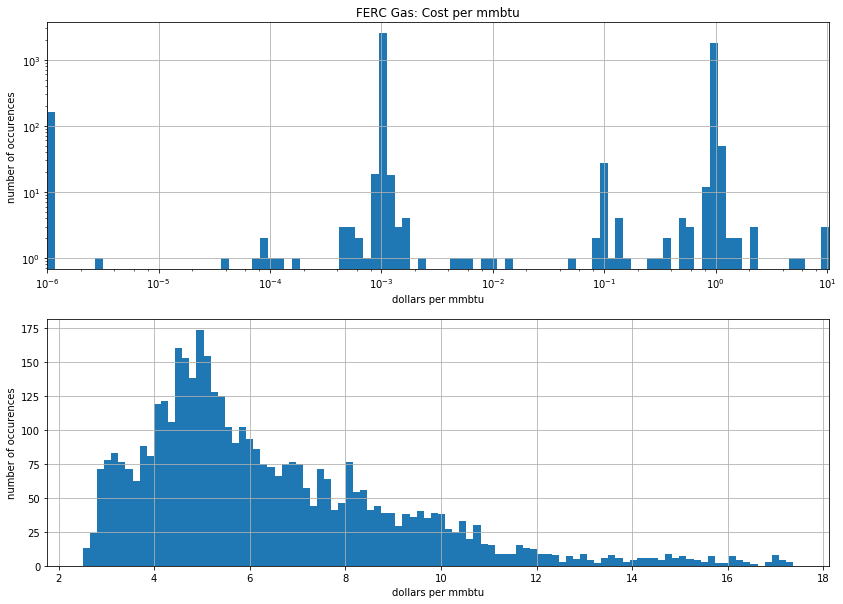

In [9]:
to_fix_cost_per_mmbtu_gas = gas.fuel_cost_per_mmbtu
fixed_cost_per_mmbtu_gas = fixit(gas.fuel_cost_per_mmbtu,2.5,17.5,[.01,1000,10])

fig, fraction_lost = showfix(to_fix_avg_heat_content_gas,fixed_cost_per_mmbtu_gas,'FERC Gas: Cost per mmbtu',\
        'dollars per mmbtu','number of occurences')

### Heat rate (mmbtu per kWh or MWh) in both EIA 923 and FERC Form 1
We'll start with looking at the range of heat rates in EIA 923 and use those values to clean the heat rate data from FERC Form 1. First we'll select the data from EIA 923 and calculate the heat rate.

## Z: Why are we opening up the EIA923 data? What do you mean by "use those values?"

In [10]:
## Select the Generation Fuel table from EIA 923
mwh_eia923 = pd.read_sql('''SELECT * FROM generation_fuel_eia923''', pudl_engine)

## Z: I'm pretty sure that selections and groupby stuff can be done using the DateTime objects natively rather than grafting on additional columns.  It's a different process though.

In [11]:
## Add a column for the year in order to get annual heat rate data
mwh_eia923['year'] = pd.DatetimeIndex(mwh_eia923['report_date']).year
# Summarize data by year for each plant; this creates a new column that reports the annual sum in each row
mwh_eia923["fuel_consumed_total_mmbtu_sum"] = mwh_eia923.groupby(["plant_id", "year"])["fuel_consumed_total_mmbtu"].transform(sum)
mwh_eia923["net_generation_mwh_sum"] = mwh_eia923.groupby(["plant_id", "year"])["net_generation_mwh"].transform(sum)

## When you're using numbers with lots of zeroes, it's best to use exponential notation for readability.  E.g. 1e6 rather than 1000000 (I edited below here).

In [12]:
# Use sum of fuel_consumed_total_mmbtu_sum and net_generation_mwh_sum to calculate annual heat rate 
# for each plant id
mwh_eia923['calculated_heat_rate_btu_per_kwh'] = \
((mwh_eia923['fuel_consumed_total_mmbtu_sum']*1e6)/(mwh_eia923['net_generation_mwh_sum']*1e3))

### Analyzing the EIA 923 heat rate data
Let's look at the quantiles and histograms for heat rate data from EIA 923 for coal and gas respectively.

In [13]:
mwh_eia923_coal = mwh_eia923[(mwh_eia923.aer_fuel_category == 'coal')]
mwh_eia923_coal.calculated_heat_rate_btu_per_kwh.quantile(q=[.01,.05,.95,.99])

0.01     7333.860712
0.05     9261.694468
0.95    27619.408928
0.99    39663.152219
Name: calculated_heat_rate_btu_per_kwh, dtype: float64

In [14]:
mwh_eia923_gas = mwh_eia923[(mwh_eia923.aer_fuel_category == 'gas')]
mwh_eia923_gas.calculated_heat_rate_btu_per_kwh.quantile(q=[.01,.05,.95,.99])

0.01     2213.432967
0.05     6282.368575
0.95    26597.569494
0.99    41953.204147
Name: calculated_heat_rate_btu_per_kwh, dtype: float64

## Z: What do we expect the heat rates to be for these different fuels, and why? What f

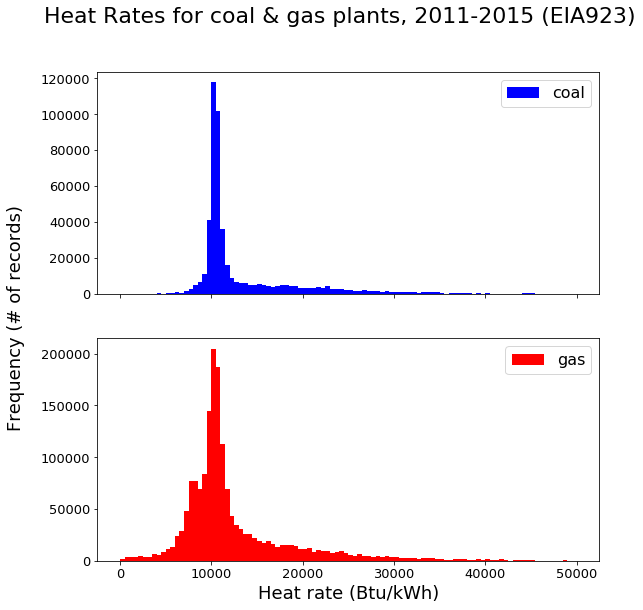

In [15]:
# Plot heat rate histogram for full data set by fuel type
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.hist(mwh_eia923_coal.calculated_heat_rate_btu_per_kwh, color= 'b', label='coal', range=(0,50000), bins=100)
ax1.legend(loc="upper right", fontsize=16)
ax1.yaxis.set_tick_params(labelsize=13)
ax2.hist(mwh_eia923_gas.calculated_heat_rate_btu_per_kwh, color= 'r', label='gas', range=(0,50000), bins=100)
ax2.legend(loc="upper right", fontsize=16)
plt.suptitle('Heat Rates for coal & gas plants, 2011-2015 (EIA923)', size=22)
ax2.set_xlabel('Heat rate (Btu/kWh)', size=18)
f.text(0.0, 0.5, 'Frequency (# of records)', ha='center', va='center', rotation='vertical', size=18)
f.set_size_inches(9,9)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.show()

### FERC Heat rates
Let's take a look at the FERC Form 1 heat rate data for coal and gas, respectively. For each data set, we'll begin by removing the values at or below zero. 

In [16]:
coal_above_zero = coal[coal.fuel_mmbtu_per_mwh > 0]
gas_above_zero = gas[gas.fuel_mmbtu_per_mwh > 0]

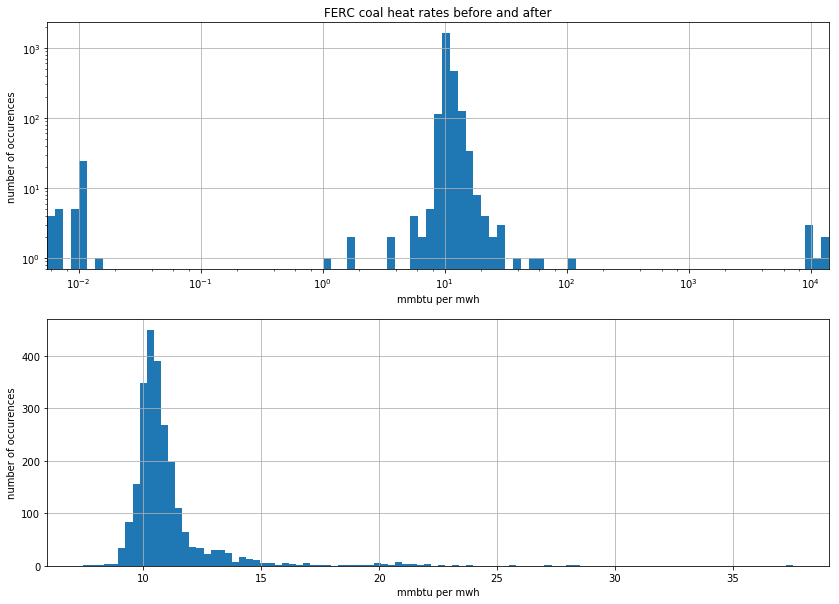

In [17]:
coal_fix = fixit(coal_above_zero.fuel_mmbtu_per_mwh,7.195,46.922,[2000,.001])
fig, fraction_lost = showfix(coal.fuel_mmbtu_per_mwh,coal_fix,'FERC coal heat rates before and after','mmbtu per mwh','number of occurences')

## Z: Again, no magic numbers 1.173, 52.207 (Why so specific?) and why 1000, 0.001?  Also, why are there two peaks in the cleaned up version of the data?  What does it mean?

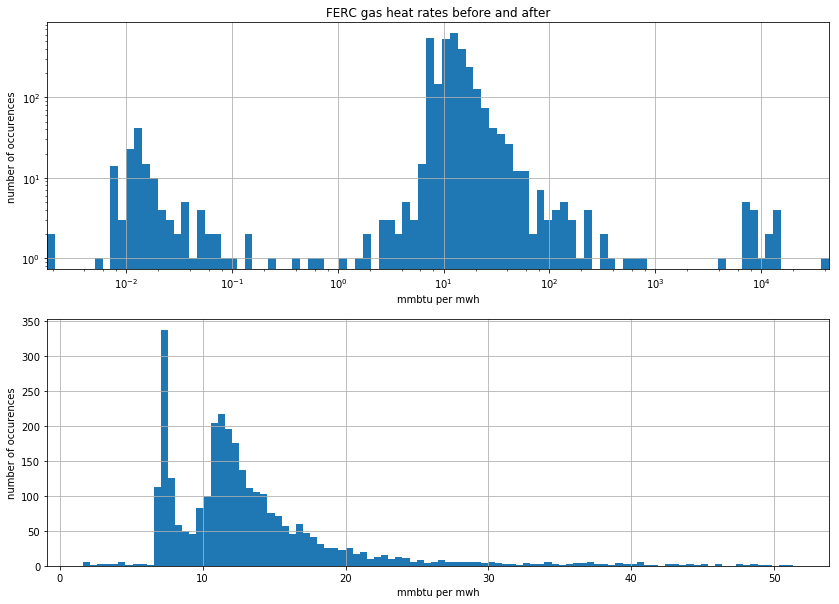

In [18]:
gas_fix = fixit(gas_above_zero.fuel_mmbtu_per_mwh,1.173,52.207,[1000,.001])
fig, fraction_lost = showfix(gas.fuel_mmbtu_per_mwh,gas_fix,'FERC gas heat rates before and after','mmbtu per mwh','number of occurences')

### FERC Cost per unit delivered
Let's take a look at histograms and quantiles FERC Form 1 cost per unit delivered for coal and gas, respectively. We'll again remove values at or below zero. This data looks quite clean as it is. 

In [19]:
to_fix_coal_cost_delivered = coal[coal.fuel_cost_per_unit_delivered > 0]
to_fix_gas_cost_delivered = gas[gas.fuel_cost_per_unit_delivered > 0]

## Z: label axes, use a legend for any plot with more than one variable.

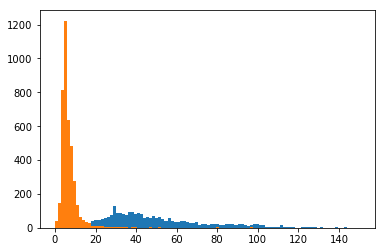

In [20]:
plt.hist(to_fix_coal_cost_delivered.fuel_cost_per_unit_delivered, bins=100,range=(0,150))
plt.hist(to_fix_gas_cost_delivered.fuel_cost_per_unit_delivered, bins=100,range=(0,150))
plt.show()

## Z: Many of of these histograms are probably going to be more meaningful if they are weighted according to the magnitude of the variable being reported -- e.g. quantity of fuel delivered here.  Otherwise a tiny delivery at a ridiculous cost counts just as much as a big delivery at a reasonable cost in the visualization.

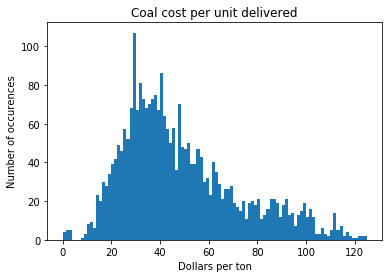

In [21]:
plt.hist(to_fix_coal_cost_delivered.fuel_cost_per_unit_delivered, bins=100,range=(0,125))
plt.title('Coal cost per unit delivered')
plt.xlabel('Dollars per ton')
plt.ylabel('Number of occurences')
plt.show()

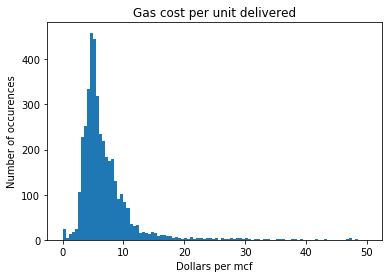

In [22]:
plt.hist(to_fix_gas_cost_delivered.fuel_cost_per_unit_delivered, bins=100,range=(0,50))
plt.title('Gas cost per unit delivered')
plt.xlabel('Dollars per mcf')
plt.ylabel('Number of occurences')
plt.show()

### FERC  Cost per unit burned
Let's take a look at histograms and quantiles FERC Form 1 cost per unit burned for coal and gas, respectively. We'll again remove values at or below zero. This data looks quite clean as it is. 

## Z: Given that we now have both EIA and FERC data floating around in the notebook, the variable names should probably reflect which data source the information at hand is coming from. Otherwise it's easy to get confused (both as a user and reader)

In [23]:
to_fix_coal_cost_burned = coal[coal.fuel_cost_per_unit_burned > 0]
to_fix_gas_cost_burned = gas[gas.fuel_cost_per_unit_burned > 0]

In [24]:
to_fix_coal_cost_burned.fuel_cost_per_unit_burned.quantile(q=[.01,.05,.5,.95,.99])

0.01     11.67106
0.05     19.08690
0.50     43.11050
0.95    100.51350
0.99    130.09643
Name: fuel_cost_per_unit_burned, dtype: float64

In [25]:
to_fix_gas_cost_burned.fuel_cost_per_unit_burned.quantile(q=[.01,.05,.5,.95,.99])

0.01     1.693
0.05     3.100
0.50     5.827
0.95    15.279
0.99    52.301
Name: fuel_cost_per_unit_burned, dtype: float64

## Z: Label Axes. Use legend. Also, this looks an awful lot like the set of plots you just did above.  Is that what you expect to see? How close are they? Also, using the same colors in every plot to refer to the same type of data (e.g. blue for coal and orange for gas, or whatever you prefer) will make it easier for readers to immediately understand what you're plotting without needing to read small labels.

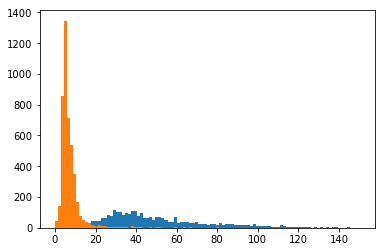

In [26]:
plt.hist(to_fix_coal_cost_burned.fuel_cost_per_unit_burned, bins=100,range=(0,150))
plt.hist(to_fix_gas_cost_burned.fuel_cost_per_unit_burned, bins=100,range=(0,150))
plt.show()

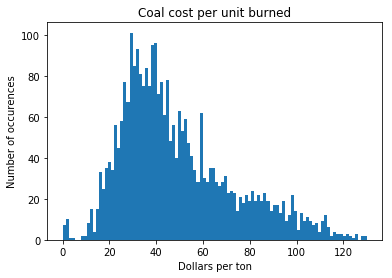

In [27]:
plt.hist(to_fix_coal_cost_burned.fuel_cost_per_unit_burned, bins=100,range=(0,130))
plt.title('Coal cost per unit burned')
plt.xlabel('Dollars per ton')
plt.ylabel('Number of occurences')
plt.show()

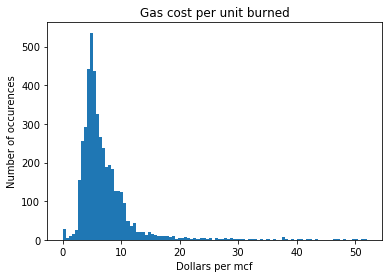

In [28]:
plt.hist(to_fix_gas_cost_burned.fuel_cost_per_unit_burned, bins=100,range=(0,52))
plt.title('Gas cost per unit burned')
plt.xlabel('Dollars per mcf')
plt.ylabel('Number of occurences')
plt.show()

### Fuel Cost per MWh for EIA and FERC

Let's take a look at fuel cost per MWh for EIA and FERC. We'll start with EIA and use the quantiles from EIA to bound the range of reasonable vales in FERC. WE'll begin by pulling the necessary columns from EIA 923 fuel receipts and costs.

In [29]:
fuel_rc = pd.read_sql('''SELECT fuel_quantity,energy_source, fuel_group, average_heat_content, fuel_cost, plant_id, report_date \
FROM fuel_receipts_costs_eia923''', con = pudl_engine)

We'll then convert the report date into years and months, and convert the fuel_cost column from cents to dollars.
## Z: again, I understand that the year/month things are easy for now, but we ought to figure out how to do the same thing with Date objects if we can and it's straightforward.

In [30]:
fuel_rc['year'] = pd.DatetimeIndex(fuel_rc['report_date']).year
fuel_rc['month'] = pd.DatetimeIndex(fuel_rc['report_date']).month
fuel_rc['fuel_cost'] = fuel_rc['fuel_cost'] * .01

We'll find sum the mmbtus per delivery and group them by fuel type. When we sort from lowest to highest, we'll know which fuel type is the dominant fuel type for the plant (the fuel type of last entry). 
## Z: I think this part where you're starting to group and sum stuff could use some additional explanation. Also I feel kinda iffy about just choosing the majority fuel (or even plurality fuel?) to determine the "real" fuel type.  Why is this necessary? Why not just look at all the coal and all the gas deliveries independently?

In [31]:
fuel_rc['mmbtu_per_delivery'] = fuel_rc['fuel_quantity'] * fuel_rc['average_heat_content']
fuel_rc['annual_mmbtu_by_fuel'] = fuel_rc.groupby(['plant_id','year','fuel_group'])\
['mmbtu_per_delivery'].transform(sum)
fuel_rc.sort_values(['annual_mmbtu_by_fuel'],inplace=True)

We'll find the cost of each delivery and sum all the deliveries for each plant in each year.
## Z: Why do we need to sum across all the deliveries for a plant in a year? Everything below here is confusing... Why is anything being broken out by year? It doesn't seem like things get segmented by year later for plotting or analysis. Why not just do it all in one swoop?  Why is it being broken out by plant_id when what you want to do is calculate a metric by fuel?

In [32]:
fuel_rc['cost_of_delivery'] = fuel_rc['mmbtu_per_delivery'] * fuel_rc['fuel_cost']
fuel_rc['total_cost_of_delivery'] = fuel_rc.groupby(['plant_id','year'])['cost_of_delivery'].transform(sum)

We'll find the total mmbtus for each plant in each year and divide the total annual cost of deliveries by the total annual mmbtus to get the weighted cost per mmbtu of deliveries for each in plant in each year.

In [33]:
fuel_rc['annual_mmbtu_total'] = fuel_rc.groupby(['plant_id','year'])\
['mmbtu_per_delivery'].transform(sum)
fuel_rc['weighted_cost_of_deliveries'] = fuel_rc['total_cost_of_delivery'] / fuel_rc['annual_mmbtu_total']

We'll drop duplicates so that there's only one record for each plant. Since keep is set to last and we've sorted in ascending order mmbtus for each fuel group, we'll be left with a plant record with the dominant fuel type.

In [34]:
fuel_rc_one_record_per_plant = fuel_rc.drop_duplicates(subset=['plant_id','year'],keep='last')

In order to calculate fuel cost per MWh, we'll need data from EIA 923 generation fuel for total mmbtus consumed and total net generation in mwh. 

In [35]:
eia_mwh = mwh_eia923[['net_generation_mwh_sum','plant_id','year','fuel_consumed_total_mmbtu_sum']]

We'll drop duplicates - we only need one annual net generation and mmbtu consumed value per plant each year.

In [36]:
eia_mwh_one_record_per_plant = eia_mwh.drop_duplicates()

We'll merge the two dataframes and calculate cost per MWh based on the total fuel consumed in mmbtu for the year multiplied by the weighted cost of deliveries and divided by the net generation in MWh for the year. 

In [37]:
eia_merged = pd.merge(fuel_rc_one_record_per_plant,eia_mwh_one_record_per_plant,\
                     on=['plant_id','year'], how='left')

In [38]:
eia_merged['cost_mwh_2'] = eia_merged['fuel_consumed_total_mmbtu_sum'] *eia_merged['weighted_cost_of_deliveries'] \
/ eia_merged['net_generation_mwh_sum']

In [39]:
eia_merged.sample(4)

,fuel_quantity,energy_source,fuel_group,average_heat_content,fuel_cost,plant_id,report_date,year,month,mmbtu_per_delivery,annual_mmbtu_by_fuel,cost_of_delivery,total_cost_of_delivery,annual_mmbtu_total,weighted_cost_of_deliveries,net_generation_mwh_sum,fuel_consumed_total_mmbtu_sum,cost_mwh_2
2935,6253.0,BIT,Coal,26.048,NaN,3947,2015-03-01,2015,3,162878.144,2.527450e+06,NaN,NaN,2.541644e+06,NaN,7.008798e+05,7214885.0,NaN
4243,217.0,DFO,Petroleum,5.176,44.479,6504,2013-01-01,2013,1,1123.192,6.629188e+06,49958.456968,1.576291e+08,6.629188e+06,23.778046,2.003221e+06,19701118.0,233.850419
8252,24082.0,BIT,Coal,25.750,NaN,1573,2009-02-01,2009,2,620111.500,6.392371e+07,NaN,NaN,6.392371e+07,NaN,1.514076e+07,151741173.0,NaN
2985,3437.0,BIT,Coal,25.450,NaN,54004,2009-05-01,2009,5,87471.650,2.668650e+06,NaN,NaN,2.860029e+06,NaN,4.179005e+06,78463809.0,NaN


### Let's organize the data
We'll split the data into coal and gas based on `fuel_group`, drop values at or below zero, and look at some quantiles for coal and gas, respectively

In [40]:
coal_eia = eia_merged[eia_merged['fuel_group'] == 'Coal']
gas_eia = eia_merged[eia_merged['fuel_group'] == 'Natural Gas']
gas_eia_no_zero = gas_eia[gas_eia['cost_mwh_2'] > 0]
coal_eia_no_zero = coal_eia[coal_eia['cost_mwh_2'] > 0]

### Let's make some plots of the data!

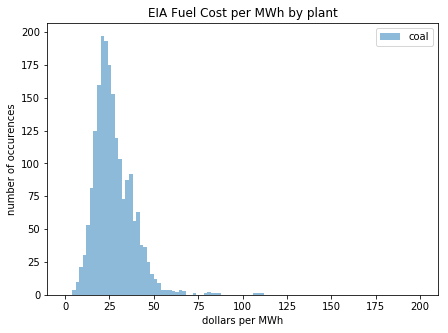

In [41]:
plt.figure(figsize=(7,5))
plt.hist(coal_eia_no_zero.cost_mwh_2,bins=100,range=(0,200),alpha=.5,label='coal')
plt.xlabel('dollars per MWh')
plt.ylabel('number of occurences')
plt.legend()
plt.title('EIA Fuel Cost per MWh by plant')
plt.show()

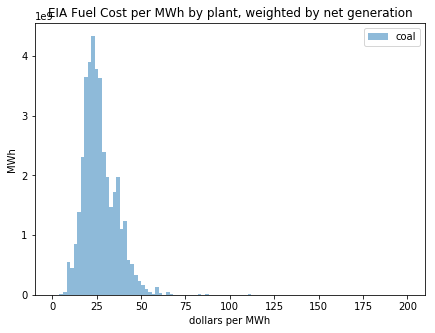

In [42]:
plt.figure(figsize=(7,5))
plt.hist(coal_eia_no_zero.cost_mwh_2,bins=100,weights=coal_eia_no_zero.net_generation_mwh_sum,range=(0,200),alpha=.5,label='coal')
plt.xlabel('dollars per MWh')
plt.ylabel('MWh')
plt.legend()
plt.title('EIA Fuel Cost per MWh by plant, weighted by net generation')
plt.show()

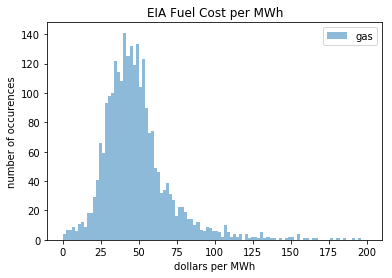

In [43]:
plt.hist(gas_eia_no_zero.cost_mwh_2,bins=100,range=(0,200),alpha=.5,label='gas')
plt.xlabel('dollars per MWh')
plt.ylabel('number of occurences')
plt.legend()
plt.title('EIA Fuel Cost per MWh')
plt.show()

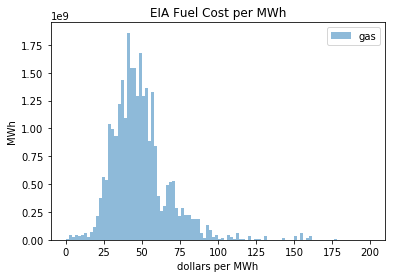

In [44]:
plt.hist(gas_eia_no_zero.cost_mwh_2,weights=gas_eia_no_zero.net_generation_mwh_sum,bins=100,range=(0,200),alpha=.5,label='gas')
plt.xlabel('dollars per MWh')
plt.ylabel('MWh')
plt.legend()
plt.title('EIA Fuel Cost per MWh')
plt.show()

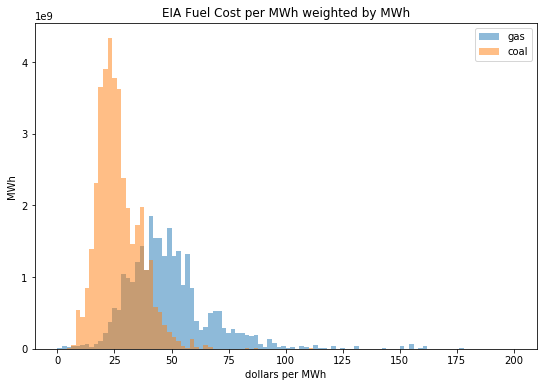

In [45]:
plt.figure(figsize=(9,6))
plt.hist(gas_eia_no_zero.cost_mwh_2,weights=gas_eia_no_zero.net_generation_mwh_sum,bins=100,range=(0,200),alpha=.5,label='gas')
plt.hist(coal_eia_no_zero.cost_mwh_2,bins=100,weights=coal_eia_no_zero.net_generation_mwh_sum,range=(0,200),alpha=.5,label='coal')
plt.xlabel('dollars per MWh')
plt.ylabel('MWh')
plt.legend()
plt.title('EIA Fuel Cost per MWh weighted by MWh')
plt.show()

## FERC Fuel cost per MWh

We'll use the quantile values from the EIA cost per MWh data to clean the F1 fuel data from FERC. There are at least two populations, one where the cost values are in dollars and one where the cost values are in cents.
## Z: Good note on dollars vs. cents -- might want to explicitly tie that to the 0.01 multiplier.  Weird combing in the fixed histogram is probably due to the selection of bin width.  Might want to make that something that's dynamically calculated to be reasonable based on the data, or that you can set when you call showfix().

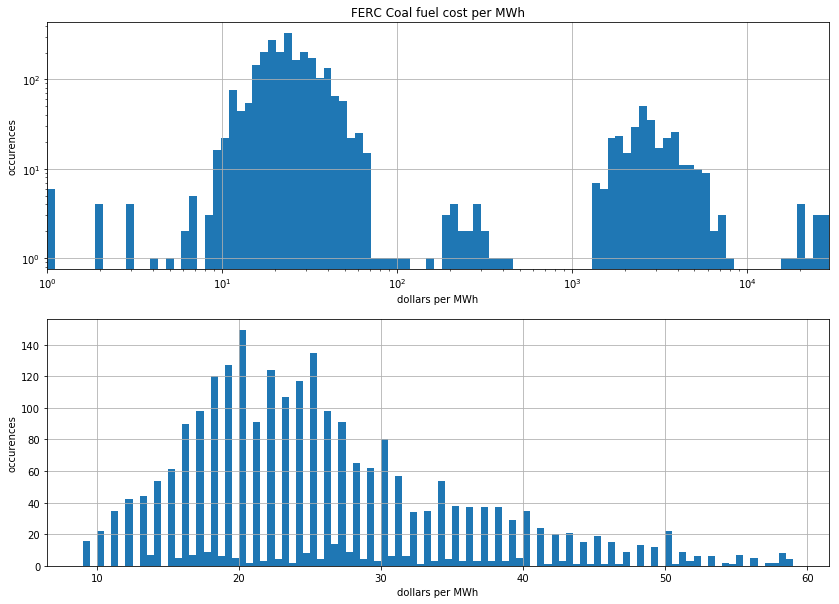

In [46]:
coal_zero_zero = coal[coal.fuel_cost_per_mwh > 0]
to_fix_coal_cost_per_mwh = coal_zero_zero.fuel_cost_per_mwh
fixed_coal_per_mwh = fixit(coal_zero_zero.fuel_cost_per_mwh,9,59,[.01])

fig, fraction_lost = showfix(to_fix_coal_cost_per_mwh,fixed_coal_per_mwh,'FERC Coal fuel cost per MWh','dollars per MWh','occurences')

## Z: The distribution below looks more challenging to clean up. Seems likely that the two humps are actually overlapping which means that any fixed boundary between them will miscategorize some values.

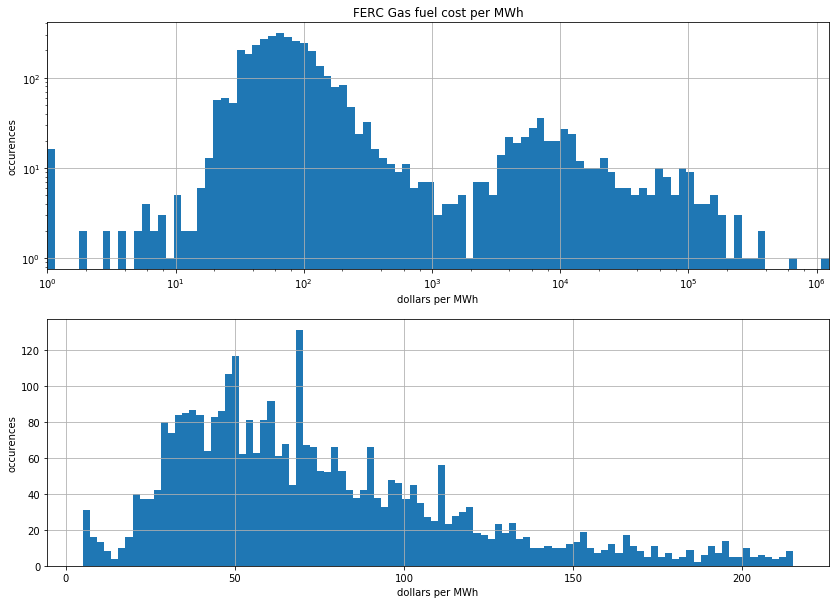

In [47]:
gas_zero_zero = gas[gas.fuel_cost_per_mwh > 0]
to_fix_gas_cost_per_mwh = gas_zero_zero.fuel_cost_per_mwh
fixed_gas_per_mwh = fixit(gas_zero_zero.fuel_cost_per_mwh,5,215,[.01])

fig, fraction_lost = showfix(to_fix_gas_cost_per_mwh,fixed_gas_per_mwh,'FERC Gas fuel cost per MWh','dollars per MWh','occurences')